In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split,KFold, cross_val_score
from sklearn.linear_model import LinearRegression , Ridge , Lasso, RidgeCV
from sklearn.preprocessing import OneHotEncoder ,RobustScaler
from xgboost import XGBRegressor
import warnings
import xgboost as xgb
import pickle
from sklearn.metrics import mean_squared_error,make_scorer
from sklearn.preprocessing import StandardScaler
from scipy.sparse import csr_matrix,hstack
import re
import os
from plotnine import *
warnings.filterwarnings("ignore")

c:\Users\WINTER\Anaconda3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\WINTER\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.TXA6YQSD3GCQQC22GEQ54J2UDCXDXHWN.gfortran-win_amd64.dll
c:\Users\WINTER\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  stacklevel=1)


# 1.读取数据

In [2]:
df=pd.read_csv("./Clean_Dataset.csv")

In [3]:
df.head(5)

,Unnamed: 0,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,0,SpiceJet,SG-8709,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1,5953
1,1,SpiceJet,SG-8157,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.33,1,5953
2,2,AirAsia,I5-764,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1,5956
3,3,Vistara,UK-995,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.25,1,5955
4,4,Vistara,UK-963,Delhi,Morning,zero,Morning,Mumbai,Economy,2.33,1,5955


# 2.数据预处理

In [18]:
df.drop("Unnamed: 0",axis=1,inplace =True)

In [13]:
df.isna().sum()

airline             0
flight              0
source_city         0
departure_time      0
stops               0
arrival_time        0
destination_city    0
class               0
duration            0
days_left           0
price               0
dtype: int64

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300153 entries, 0 to 300152
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   airline           300153 non-null  object 
 1   flight            300153 non-null  object 
 2   source_city       300153 non-null  object 
 3   departure_time    300153 non-null  object 
 4   stops             300153 non-null  object 
 5   arrival_time      300153 non-null  object 
 6   destination_city  300153 non-null  object 
 7   class             300153 non-null  object 
 8   duration          300153 non-null  float64
 9   days_left         300153 non-null  int64  
 10  price             300153 non-null  int64  
dtypes: float64(1), int64(2), object(8)
memory usage: 25.2+ MB


In [15]:
df.columns.tolist() 

['airline',
 'flight',
 'source_city',
 'departure_time',
 'stops',
 'arrival_time',
 'destination_city',
 'class',
 'duration',
 'days_left',
 'price']

In [19]:
df.price = np.log(df.price)

# 3.数据可视化

In [52]:
df1 = df.copy()
df1=df1.replace({'Economy':'经济舱','Business':'商务舱'})
class_count=df1['class'].value_counts().reset_index()

# class_count
fig = px.pie(class_count, values='class', names='index',color_discrete_sequence=px.colors.sequential.PuBu[2:],width=800, height=500)
fig.update_layout(
    title={  
        "text":'机票类别占比',
        "y":0.96,  
        "x":0.5,
        "xanchor":"center",  
    }
)
fig.update_layout(font =dict(size=15))
fig.show()
fig.write_image('bus.png',scale=2)

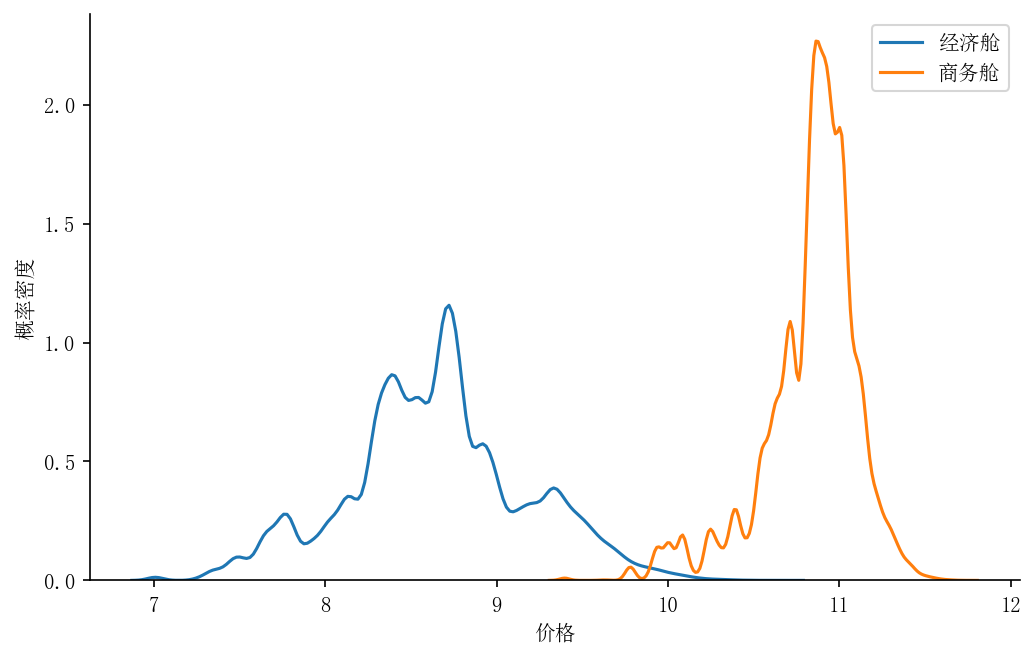

In [64]:
f, ax = plt.subplots(figsize=(8, 5),dpi=150)
plt.rcParams['font.sans-serif'] = ['SimSun']
sns.distplot(df.loc[df["class"]=='Economy',"price"],hist=False,label='经济舱')
sns.distplot(df.loc[df["class"]=='Business',"price"],hist=False,label='商务舱')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.legend()
plt.xlabel("价格")
plt.ylabel("概率密度")
# plt.show()
plt.savefig("bus2.png")

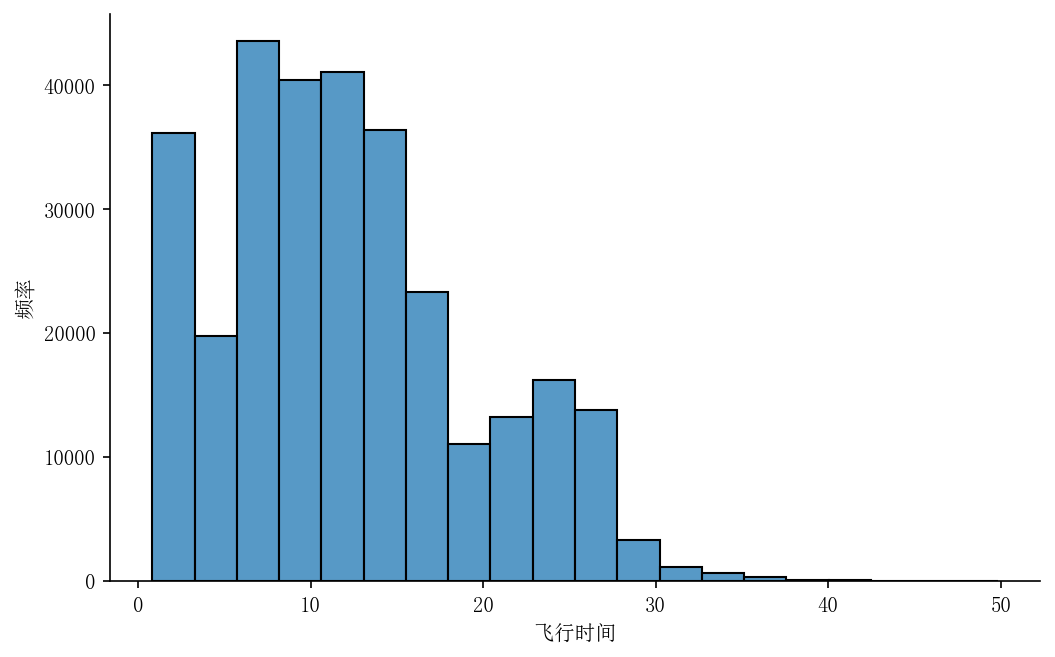

In [67]:
# plot the distribution of column  duration
fig = plt.figure(figsize=(8,5), dpi = 150)
ax = plt.axes()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
sns.histplot(data=df, x="duration",bins=20)
# plt.hist(df['duration'])
plt.rcParams['font.sans-serif'] = ['SimSun']
plt.xlabel('飞行时间')
plt.ylabel("频率")
plt.savefig("duration1.png")


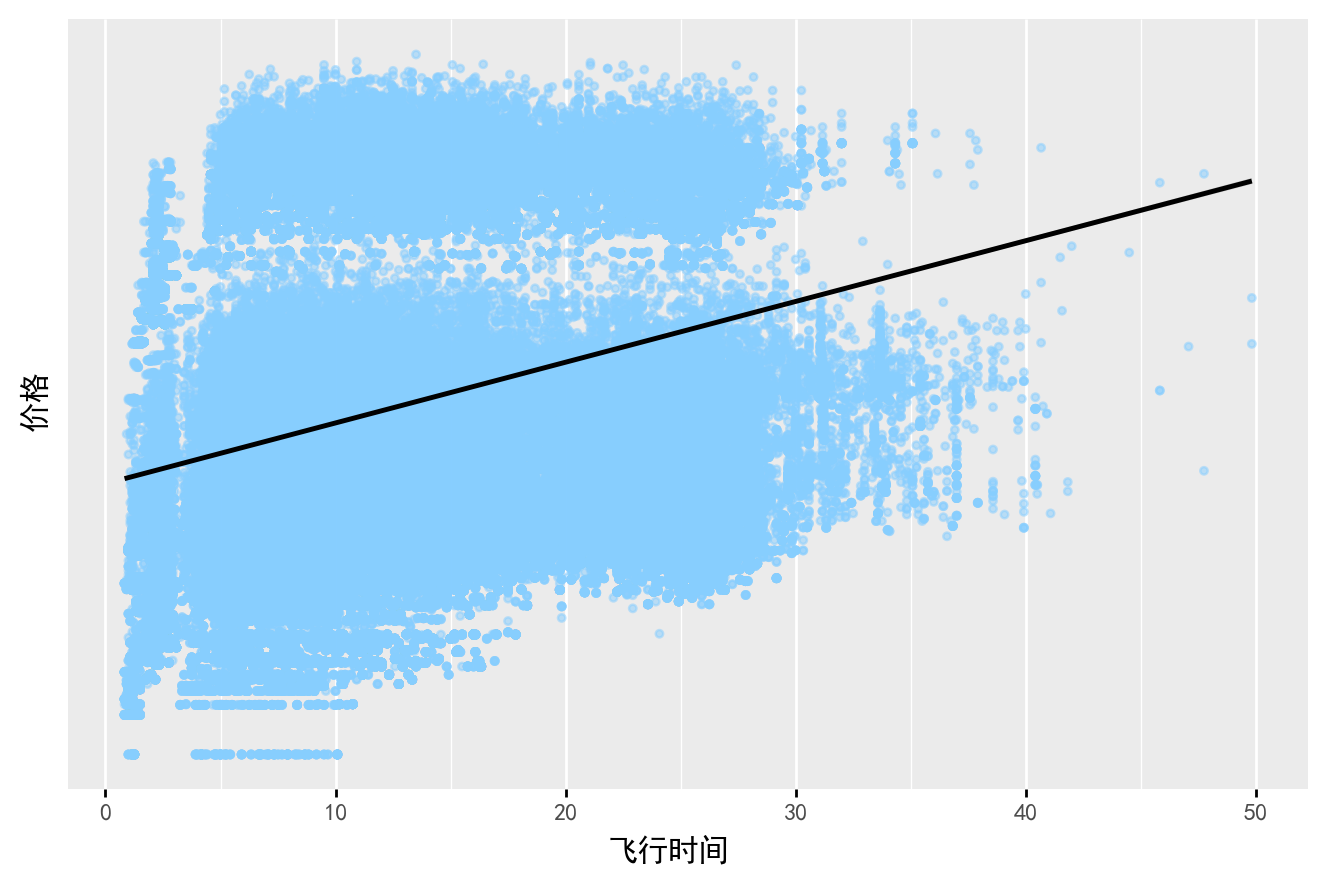

<ggplot: (-9223371942059454604)>

In [122]:
(
    ggplot(df, aes('duration', 'price'))
    +xlab("飞行时间")
    +ylab("价格")
    + geom_point(fill='#87CEFF', color='#87CEFF', size=1, shape='o',alpha=0.5)
    + geom_smooth(method='lm', span=0.4, se=True, color='k')
    + scale_y_continuous(breaks = np.arange(0, 150, 25))
    + theme(text=element_text(family="SimHei"),figure_size = (8, 5),
        dpi = 200)

)

Text(0, 0.5, '价格')

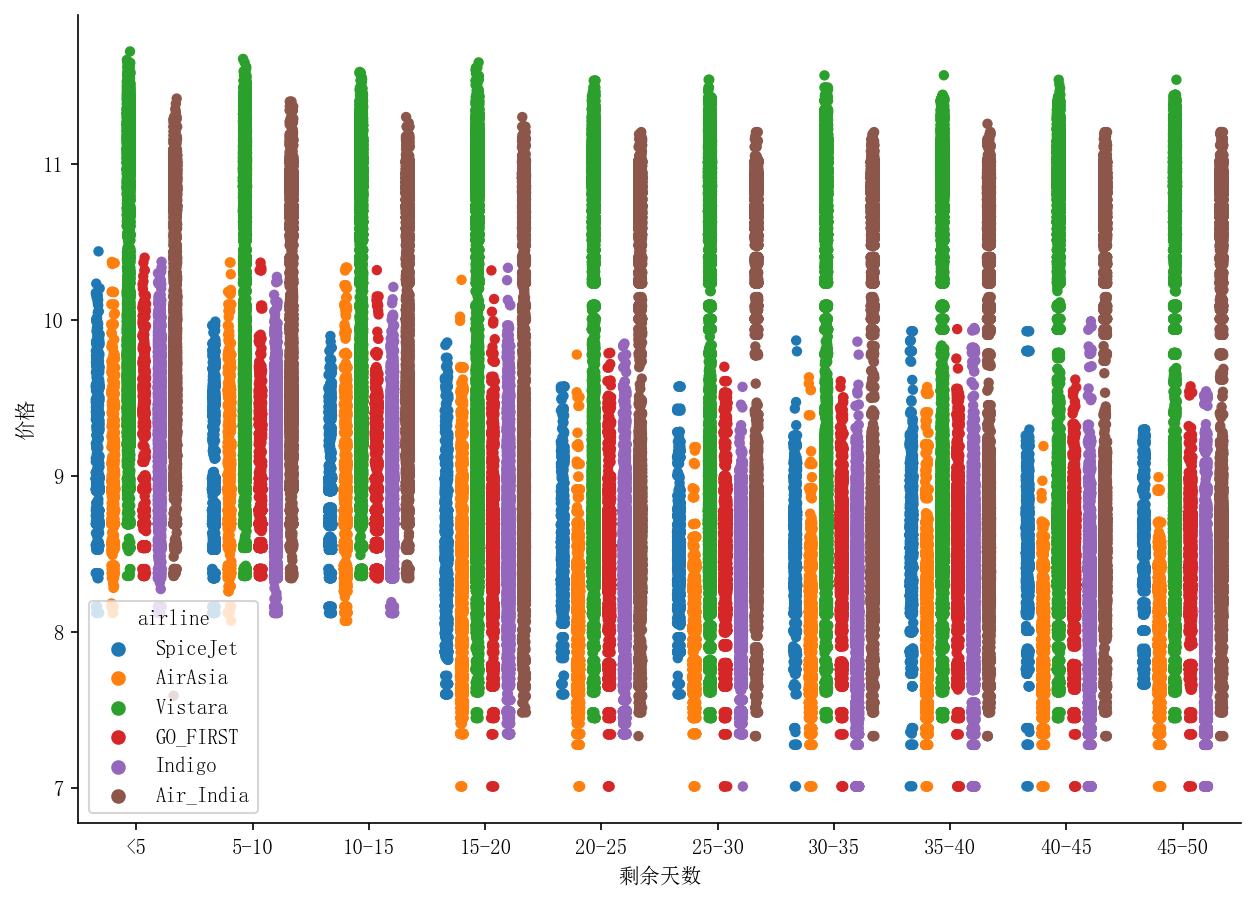

In [23]:

df1 = df.copy()
df1.days_left1 = 'd'
df1.loc[df1.days_left<5,'days_left1'] = '<5'
df1.loc[(df1.days_left>=5) & (df1.days_left<10),'days_left1'] = '5-10'
df1.loc[(df1.days_left>=10) & (df1.days_left<15),'days_left1'] = '10-15'
df1.loc[(df1.days_left>=15) & (df1.days_left<20),'days_left1'] = '15-20'
df1.loc[(df1.days_left>=20) & (df1.days_left<25),'days_left1'] = '20-25'
df1.loc[(df1.days_left>=25) & (df1.days_left<30),'days_left1'] = '25-30'
df1.loc[(df1.days_left>=30) & (df1.days_left<35),'days_left1'] = '30-35'
df1.loc[(df1.days_left>=35) & (df1.days_left<40),'days_left1'] = '35-40'
df1.loc[(df1.days_left>=40) & (df1.days_left<45),'days_left1'] = '40-45'
df1.loc[(df1.days_left>=45) & (df1.days_left<50),'days_left1'] = '45-50'
plt.figure(figsize = (10,7),dpi=150) 
ax = plt.axes()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.rcParams['font.sans-serif'] = ['SimSun']
sns.stripplot(x='days_left1', y="price", hue="airline", data=df1, dodge=True); #dodge表示是否将两种蜂巢图分开

plt.xlabel("剩余天数")
plt.ylabel("价格")

In [49]:

class_count=df['airline'].value_counts().reset_index()
# class_count
fig = px.pie(class_count, values='airline', names='index',color_discrete_sequence=px.colors.sequential.PuBu[2:],width=800, height=500)
fig.update_layout(
    title={  
        "text":'航空公司占比',
        "y":0.96,  
        "x":0.5,
        "xanchor":"center",  
    }
)
fig.update_layout(font =dict(size=15))
fig.show()
fig.write_image('airline.png',scale=2)



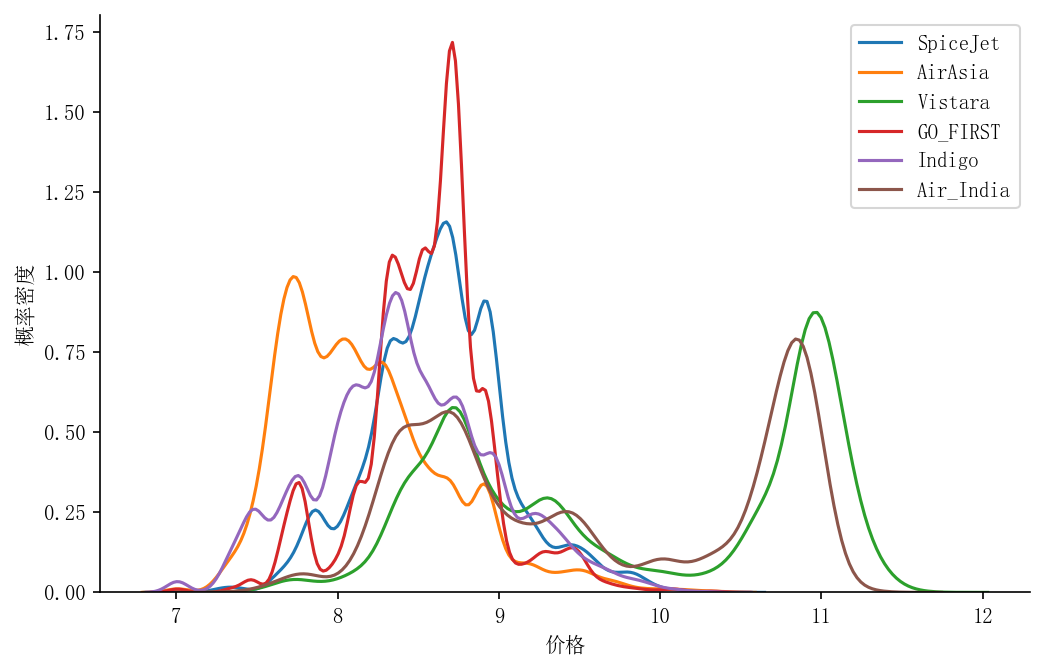

In [25]:
airlines = df.airline.unique()
f, ax = plt.subplots(figsize=(8, 5),dpi=150)
plt.rcParams['font.sans-serif'] = ['SimSun']
sns.distplot(df[df["airline"]==airlines[0]]["price"],hist=False,label=airlines[0])
sns.distplot(df[df["airline"]==airlines[1]]["price"],hist=False,label=airlines[1])
sns.distplot(df[df["airline"]==airlines[2]]["price"],hist=False,label=airlines[2])
sns.distplot(df[df["airline"]==airlines[3]]["price"],hist=False,label=airlines[3])
sns.distplot(df[df["airline"]==airlines[4]]["price"],hist=False,label=airlines[4])
sns.distplot(df[df["airline"]==airlines[5]]["price"],hist=False,label=airlines[5])

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.legend()
plt.xlabel("价格")
plt.ylabel("概率密度")
plt.show()

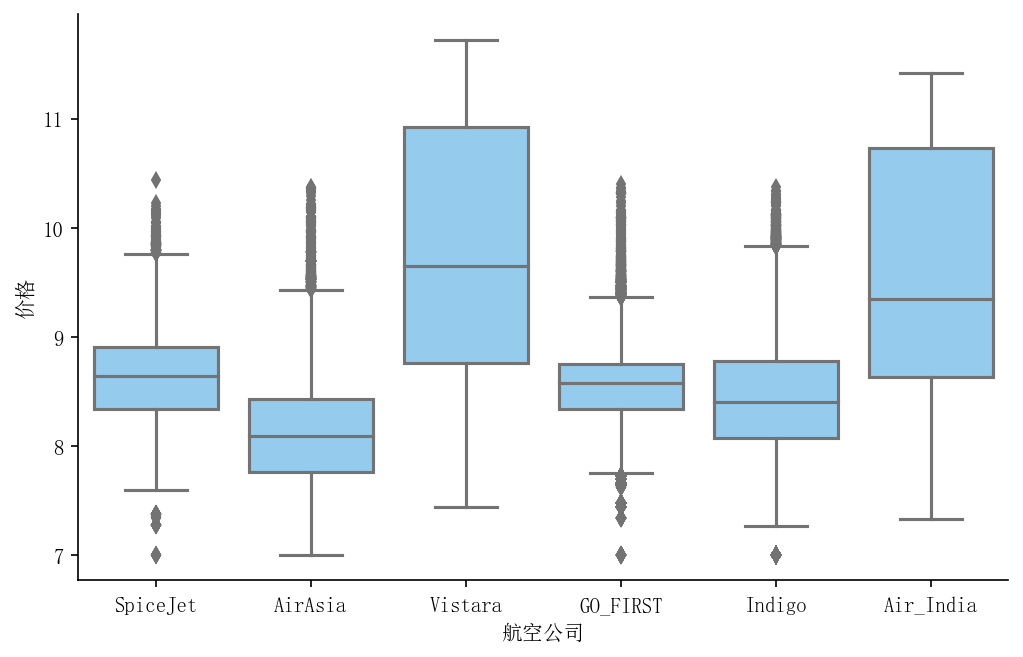

In [66]:
fig = plt.figure(figsize=(8,5), dpi = 150)
ax = plt.axes()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.rcParams['font.sans-serif'] = ['SimSun']
sns.boxplot(x='airline',y='price',data=df,color = '#87CEFA')#palette='hl)
plt.xlabel("航空公司")
plt.ylabel("价格")
plt.savefig("airline2.png")

In [31]:
class_count=df['source_city'].value_counts().reset_index()
# class_count
fig = px.pie(class_count, values='source_city', names='index',color_discrete_sequence=px.colors.sequential.PuBu,width=800, height=500)
fig.update_layout(
    title={  
        "text":'起飞城市占比',
        "y":0.96,  
        "x":0.5,
        "xanchor":"center",  
    }
)
fig.update_layout(font =dict(size=15))
fig.show()
fig.write_image('source.png',scale=2)


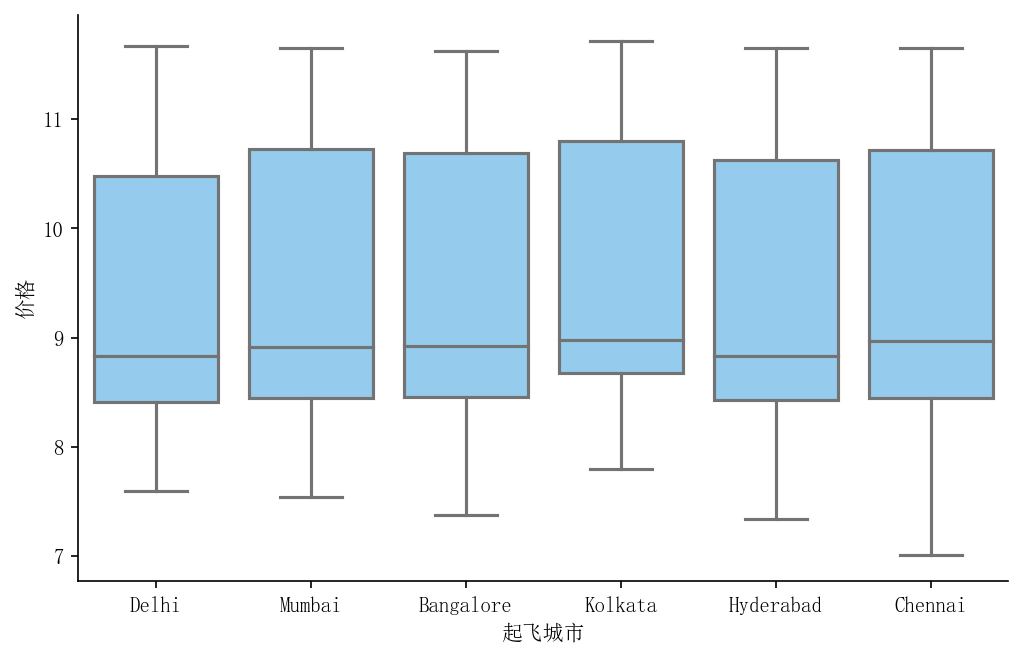

In [100]:
fig = plt.figure(figsize=(8,5), dpi = 150)
ax = plt.axes()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.rcParams['font.sans-serif'] = ['SimSun']
sns.boxplot(x='source_city',y='price',data=df,color = '#87CEFA')
plt.xlabel("起飞城市")
plt.ylabel("价格")
plt.savefig('source2.png')

In [ ]:
destination_city_count=df['destination_city'].value_counts().reset_index()
# fig = px.pie(destination_city_count, values='count', names='destination_city',title='destination_city ')
fig = px.pie(destination_city_count, values='destination_city', names='index',color_discrete_sequence=px.colors.sequential.PuBu)
fig.update_layout(
    title={  
        "text":'落地城市占比',
        "y":0.96,  
        "x":0.5,
        "xanchor":"center",  
    }
)
fig.show()
fig.write_image('arrival.png')

Text(0, 0.5, '价格')

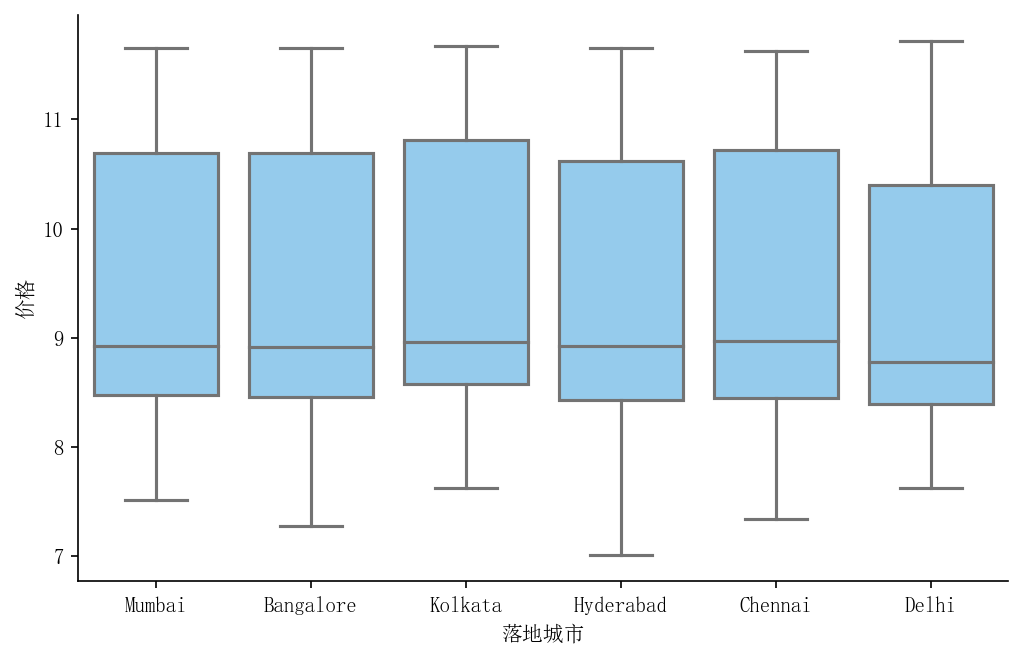

In [102]:
fig = plt.figure(figsize=(8,5), dpi = 150)
ax = plt.axes()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.rcParams['font.sans-serif'] = ['SimSun']
sns.boxplot(x='destination_city',y='price',data=df,color='#87CEFA')
plt.xlabel("落地城市")
plt.ylabel("价格")

In [104]:


df1 = df.copy()
df1 = df1.replace({'Morning':'上午','Early_Morning':'早晨','Evening':'傍晚','Night':'深夜','Afternoon':'下午','Late_Night':'凌晨'})
class_count=df1['departure_time'].value_counts().reset_index()

# class_count
fig = px.pie(class_count, values='departure_time', names='index',color_discrete_sequence=px.colors.sequential.PuBu[1:],width=800, height=500)
fig.update_layout(
    title={  
        "text":'起飞时间段占比',
        "y":0.96,  
        "x":0.5,
        "xanchor":"center",  
    }
)
fig.update_layout(font =dict(size=15))
fig.show()
fig.write_image('de.png',scale=2)


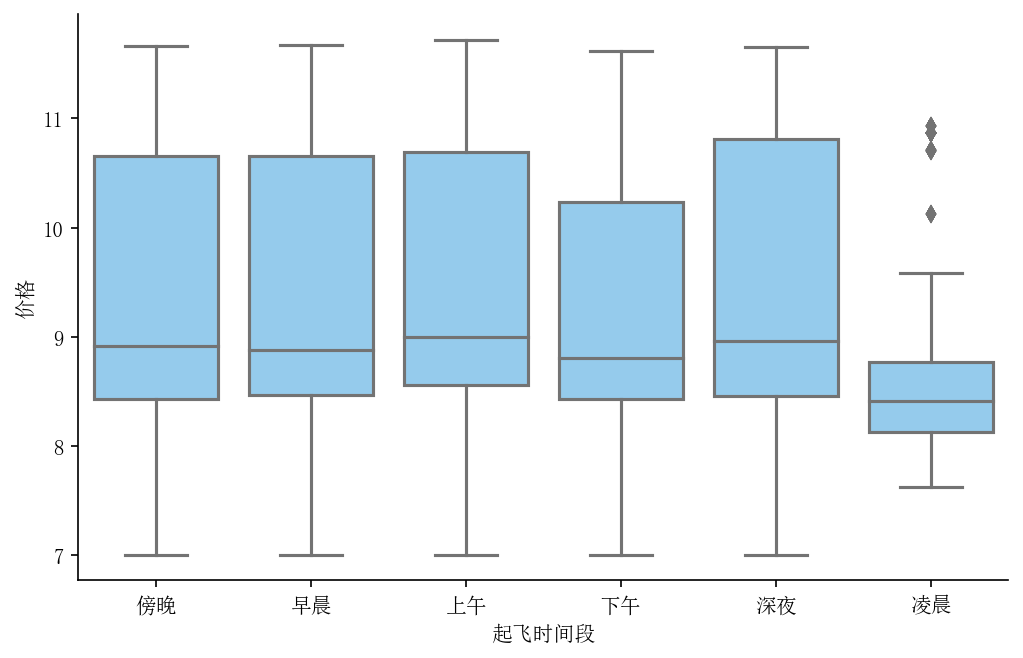

In [105]:
fig = plt.figure(figsize=(8,5), dpi = 150)
ax = plt.axes()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.rcParams['font.sans-serif'] = ['SimSun']
sns.boxplot(x='departure_time',y='price',data=df1,color='#87CEFA')
plt.xlabel("起飞时间段")
plt.ylabel("价格")
plt.savefig("de2.png")

In [106]:
df['arrival_time'].unique()
arrival_time_count=df['arrival_time'].value_counts().reset_index()
print(arrival_time_count)
fig = px.pie(arrival_time_count, values='arrival_time', names='index',color_discrete_sequence=px.colors.sequential.PuBu)
fig.update_layout(
    title={  
        "text":'落地时间段占比',
        "y":0.96,  
        "x":0.5,
        "xanchor":"center",  
    }
)
fig.show()
fig.write_image('de.png')


           index  arrival_time
0          Night         91538
1        Evening         78323
2        Morning         62735
3      Afternoon         38139
4  Early_Morning         15417
5     Late_Night         14001


Text(0, 0.5, '价格')

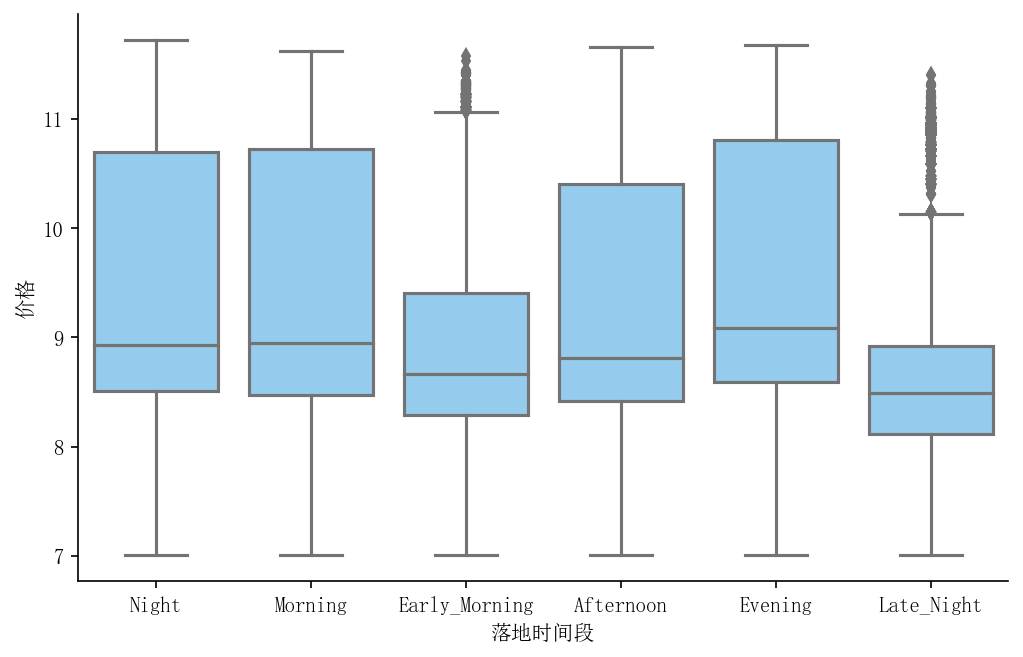

In [107]:
fig = plt.figure(figsize=(8,5), dpi = 150)
ax = plt.axes()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.rcParams['font.sans-serif'] = ['SimSun']
sns.boxplot(x='arrival_time',y='price',data=df,color ='#87CEFA')
plt.xlabel("落地时间段")
plt.ylabel("价格")

In [108]:

df1 = df.copy()
df1 = df1.replace({"one":'一次','zero':'0次','two_or_more':'两次及以上'})
class_count=df1['stops'].value_counts().reset_index()
# class_count
fig = px.pie(class_count, values='stops', names='index',color_discrete_sequence=px.colors.sequential.PuBu[2:],width=800, height=500)
fig.update_layout(
    title={  
        "text":'停靠次数占比',
        "y":0.96,  
        "x":0.5,
        "xanchor":"center",  
    }
)
fig.update_layout(font =dict(size=15))
fig.show()
fig.write_image('stops.png',scale=2)

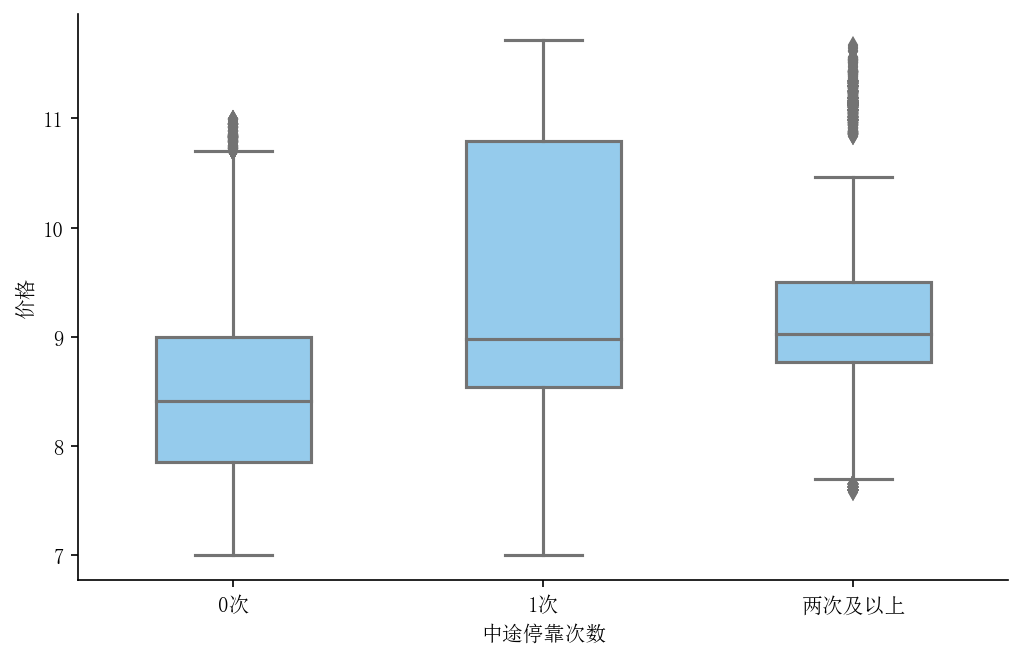

In [109]:
fig = plt.figure(figsize=(8,5), dpi = 150)
ax = plt.axes()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.rcParams['font.sans-serif'] = ['SimSun']
sns.boxplot(x='stops',y='price',data=df,color='#87CEFA',width=0.5)
plt.xticks([0,1,2],['0次','1次','两次及以上'])
plt.xlabel("中途停靠次数")
plt.ylabel("价格")
plt.savefig("stops2.png")

# 4.数据标准化、数据划分

In [20]:
def data_preprocess(df):
    df.drop('flight',axis=1,inplace=True)
    # 哑变量化
    varss=['airline','source_city','departure_time', 'stops', 'arrival_time','destination_city', 'class']
    df1= pd.get_dummies(df,drop_first=False,columns=varss)
    # 标准化
    varss=['duration','days_left']
    df1.loc[:,varss]=(df1.loc[:,varss]-(df1.loc[:,varss]).mean())/(df1.loc[:,varss].std())
    x=df1.drop(['price'],axis=1)
    y=df1['price']
    # train_test_split
    X_train,X_test,y_train,y_test = train_test_split(x,y,test_size=0.25,random_state=42)
    return X_train,X_test,y_train,y_test 
    

In [21]:
X_train,X_test,y_train,y_test= data_preprocess(df)

# 5.模型分析

## 5.1LinearRegression

In [112]:
def fit_predict(model,X_train=X_train,y_train=y_train,X_test=X_test,y_test=y_test):
    model.fit(X_train,y_train)
    predict= model.predict(X_test)
    RMSE = np.sqrt(mean_squared_error(y_test, predict)) 
    return RMSE

In [113]:
lr=LinearRegression()
fit_predict(lr)

0.32228452657544504

## 5.2LASSO

In [116]:
from sklearn.linear_model import Lasso, LassoCV
Lambdas = np.logspace(-4, 20, 20)
# 构造空列表，用于存储模型的偏回归系数
lasso_cofficients = []
lasso_cv = LassoCV(alphas=Lambdas, normalize=True, cv=10, max_iter=10000)
lasso_cv.fit(X_train, y_train)
# 输出最佳的lambda值
lasso_best_alpha = lasso_cv.alpha_ 
lasso = Lasso(alpha=lasso_best_alpha, normalize=True, max_iter=10000)
fit_predict(lasso)

0.35216765462250443

# 5.3 XGBoost

In [118]:
from xgboost import XGBRegressor
xgb = XGBRegressor(n_estimators= 400 , max_depth= 7 , learning_rate = 0.01)
fit_predict(xgb)

0.2683912064499387

## 5.4Neural Network（核心模型，详细代码见py文件）

In [71]:
# 划分训练集和验证集，验证集用于早停
X_train,X_valid,y_train,y_valid = train_test_split(X_train,y_train,test_size=0.1,random_state=42)
train = pd.concat([X_train,y_train],axis=1)
train.to_csv('./train.csv')
test = pd.concat([X_test,y_test],axis=1)
test.to_csv('./test.csv')
valid = pd.concat([X_valid,y_valid],axis=1)
valid.to_csv('./valid.csv')

### 神经网络(命令行中执行)

- python main.py --lr 0.005 --num_layers 4 --hidden_size 64 --epoch 50 --batch 2048 --dropout 0.0
- python main.py --lr 0.005 --num_layers 4 --hidden_size 64 --epoch 50 --batch 2048 --dropout 0.5

### 神经网络调参结果可视化

In [56]:
def analyze_log(file):
    '''
    从logfile中提取valid loss
    '''
    parent_dir = 'C:/Users/WINTER/Desktop/Python基础/report/logs/'
    f = open(os.path.join(parent_dir,file),'r')
    lines = f.read()    
    valid_loss = re.findall('Valid Loss 0.\d+',lines)
    valid_loss = [float(line[10:]) for line in valid_loss]
    return valid_loss

    

In [98]:
layer3 = 'epoch_50_lr_0.005_batch_2048_num_layers_3_hidden_size_64_optimizer_SGD_dropout_0.0_batchnorm_1.log'
layer4 = 'epoch_50_lr_0.005_batch_2048_num_layers_4_hidden_size_64_optimizer_SGD_dropout_0.0_batchnorm_1.log'
layer5 = 'epoch_50_lr_0.005_batch_2048_num_layers_5_hidden_size_64_optimizer_SGD_dropout_0.0_batchnorm_1.log'
layer6 = 'epoch_50_lr_0.005_batch_2048_num_layers_6_hidden_size_64_optimizer_SGD_dropout_0.0_batchnorm_1.log'

loss = {}
loss['layer3'] = analyze_log(layer3)
loss['layer4'] = analyze_log(layer4)
loss['layer5'] = analyze_log(layer5)
loss['layer6'] = analyze_log(layer6)



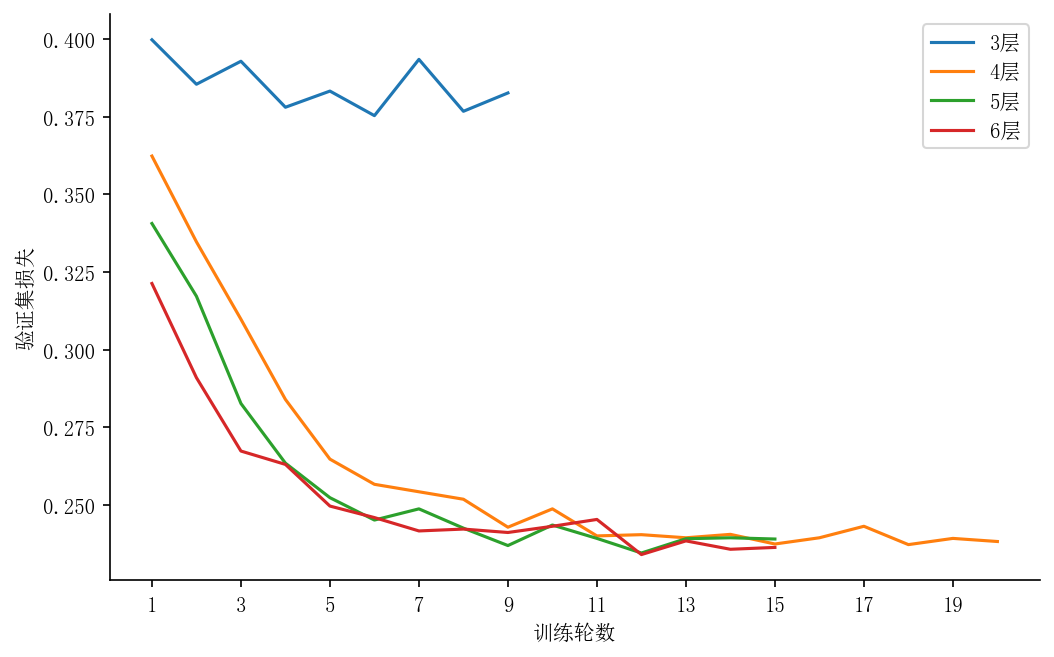

In [99]:
plt.figure(figsize=(8,5),dpi=150)
ax = plt.axes()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.rcParams['font.sans-serif'] = ['SimSun']
x = list(range(1,1+len(loss['layer3'])))

plt.plot(x,loss['layer3'],label = '3层')
x = list(range(1,1+len(loss['layer4'])))
plt.plot(x,loss['layer4'],label = '4层')
x = list(range(1,1+len(loss['layer5'])))
plt.plot(x,loss['layer5'],label ='5层')
x = list(range(1,1+len(loss['layer6'])))
plt.plot(x,loss['layer6'],label = '6层')
plt.xticks(list(range(1,20,2)))
plt.xlabel('训练轮数')
plt.ylabel("验证集损失")
plt.legend()
plt.savefig('layer.png')


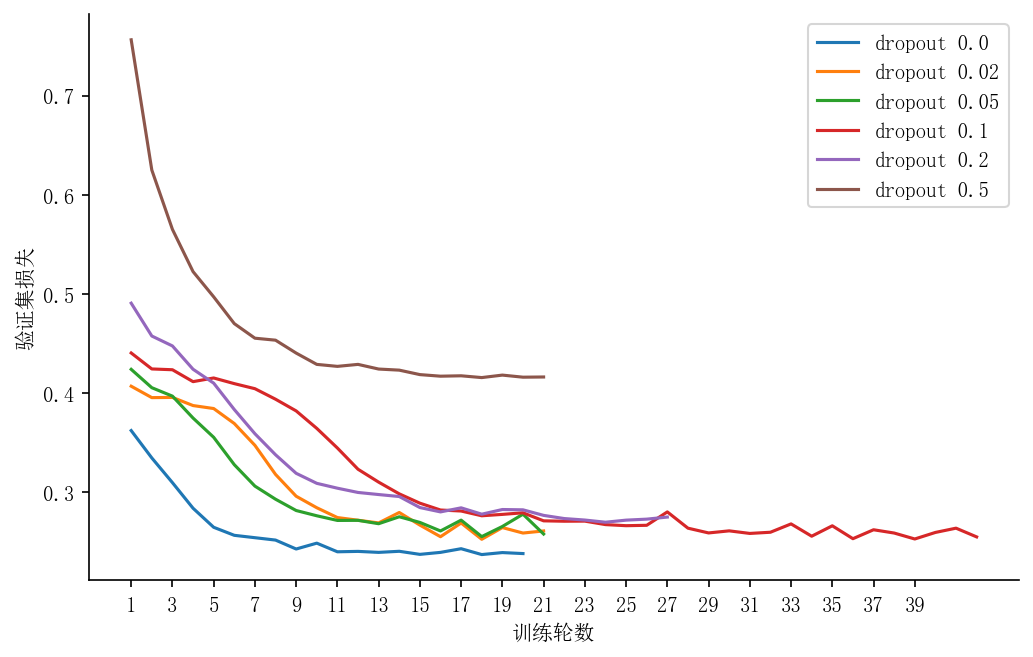

In [119]:
layer3 = 'epoch_50_lr_0.005_batch_2048_num_layers_4_hidden_size_64_optimizer_SGD_dropout_0.0_batchnorm_1.log'
layer4 = 'epoch_50_lr_0.005_batch_2048_num_layers_4_hidden_size_64_optimizer_SGD_dropout_0.02_batchnorm_1.log'
layer5 = 'epoch_50_lr_0.005_batch_2048_num_layers_4_hidden_size_64_optimizer_SGD_dropout_0.05_batchnorm_1.log'
layer6 = 'epoch_50_lr_0.005_batch_2048_num_layers_4_hidden_size_64_optimizer_SGD_dropout_0.1_batchnorm_1.log'
layer7 = 'epoch_50_lr_0.005_batch_2048_num_layers_4_hidden_size_64_optimizer_SGD_dropout_0.2_batchnorm_1.log'
layer8 = 'epoch_50_lr_0.005_batch_2048_num_layers_4_hidden_size_64_optimizer_SGD_dropout_0.5_batchnorm_1.log'
# layer7 = 'epoch_50_lr_0.005_batch_2048_num_layers_4_hidden_size_64_optimizer_SGD_dropout_0.05_batchnorm_1.log'


loss = {}
loss['layer3'] = analyze_log(layer3)
loss['layer4'] = analyze_log(layer4)
loss['layer5'] = analyze_log(layer5)
loss['layer6'] = analyze_log(layer6)
loss['layer7'] = analyze_log(layer7)
loss['layer8'] = analyze_log(layer8)

plt.figure(figsize=(8,5),dpi=150)
ax = plt.axes()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.rcParams['font.sans-serif'] = ['SimSun']
x = list(range(1,1+len(loss['layer3'])))
plt.plot(x,loss['layer3'],label = 'dropout 0.0')
x = list(range(1,1+len(loss['layer4'])))
plt.plot(x,loss['layer4'],label = 'dropout 0.02')
x = list(range(1,1+len(loss['layer5'])))
plt.plot(x,loss['layer5'],label ='dropout 0.05')
x = list(range(1,1+len(loss['layer6'])))
plt.plot(x,loss['layer6'],label = 'dropout 0.1')
x = list(range(1,1+len(loss['layer7'])))
plt.plot(x,loss['layer7'],label = 'dropout 0.2')
x = list(range(1,1+len(loss['layer8'])))
plt.plot(x,loss['layer8'],label = 'dropout 0.5')
plt.xticks(list(range(1,40,2)))
plt.xlabel('训练轮数')
plt.ylabel("验证集损失")
plt.legend()
plt.savefig('dropout.png')
